<a href="https://colab.research.google.com/github/devjaind123/Brain-Tumor-Classification/blob/main/TE_MINOR_PROJECT_BRAIN_TUMOR_CLASSIFICATION_%7C_ResNet50_%7C_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import random
import itertools
import cv2
import imutils
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Dropout,GlobalAveragePooling2D,Flatten,Input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet50
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.inception_v3 import preprocess_input
from keras.applications.resnet import preprocess_input

In [3]:
from IPython.display import clear_output
!pip install imutils
clear_output()

# Data Preparation & Preprocessing

In [4]:
IMG_PATH = "/content/drive/MyDrive/Brain Tumor/"
categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

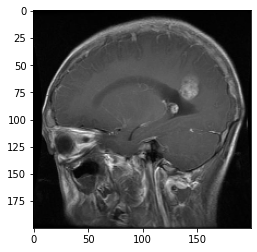

In [5]:
for category in categories:
    path = os.path.join(IMG_PATH,category)  # create path to the tumors
    for img in os.listdir(path):  # iterate over each image per tumors
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        img_array = cv2.resize(img_array, (200, 200))
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!\
        break
    break

In [6]:
#Split Dataset into Training, Testing and Validation

In [7]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

In [8]:
for cls in categories:
    os.makedirs('train/' + cls)
    os.makedirs('val/' + cls)
    os.makedirs('test/' + cls)

In [9]:
# Creating partitions of the data after shuffeling
src = IMG_PATH + cls # Folder to copy images from

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(allFileNames)* (1 - test_ratio))])

In [10]:
train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

In [11]:
print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

Total images:  827
Training:  661
Validation:  83
Testing:  83


In [12]:
for cls in categories:
       # Copy-pasting images
       for name in train_FileNames:
              shutil.copy(name, 'train/' + cls)

       for name in val_FileNames:
              shutil.copy(name, 'val/' + cls)

       for name in test_FileNames:
               shutil.copy(name, 'test/' + cls)

In [13]:
TRAIN_DIR = '/content/train/'
TEST_DIR = '/content/test/'
VAL_DIR = '/content/val/'

In [15]:
def load_data(dir_path, img_size=(224,224)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [16]:
IMG_SIZE = (224, 224)

In [17]:
# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)

100%|██████████| 4/4 [00:09<00:00,  2.44s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


2644 images loaded from /content/train/ directory.


100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


332 images loaded from /content/val/ directory.


100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

332 images loaded from /content/test/ directory.


In [18]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

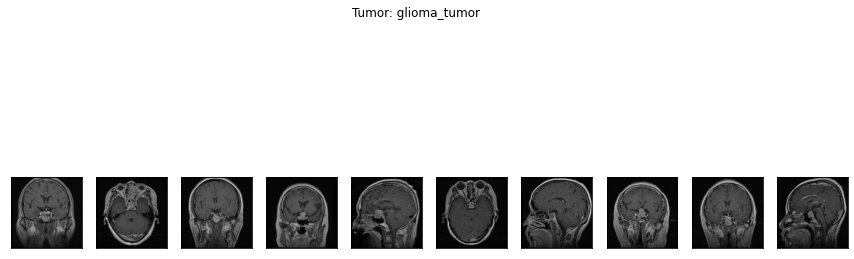

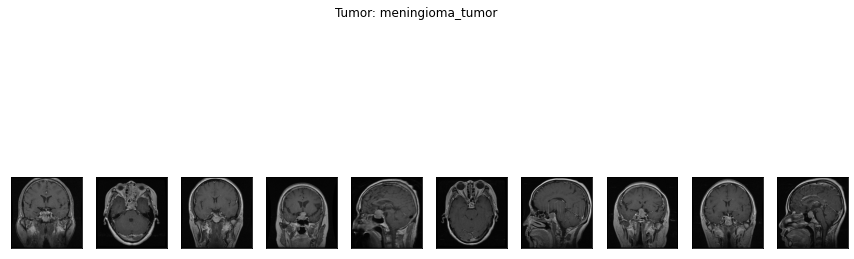

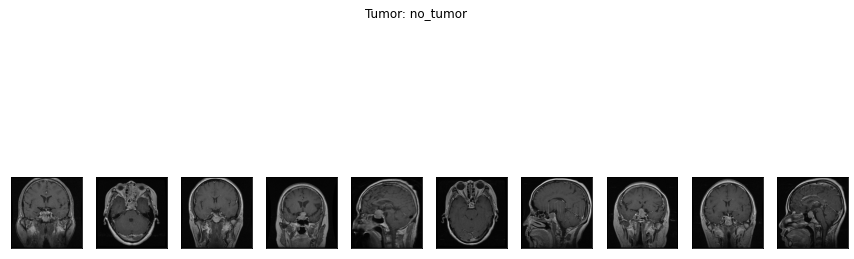

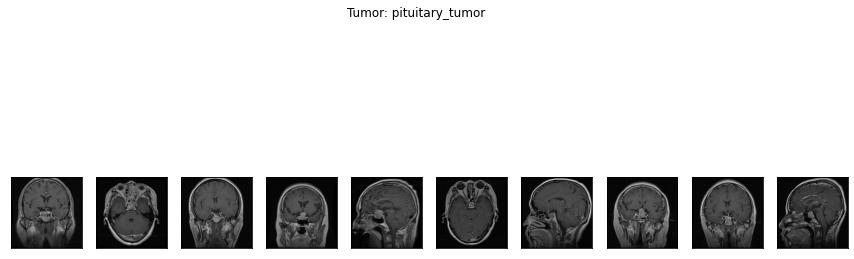

In [19]:
plot_samples(X_train, y_train, labels, 10)

# Crop the image

In [20]:
#Finds the extreme points on the image and crops the rectangular out of them

def crop_imgs(set_name, add_pixels_value=0):
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

Let's look at example what this function will do with MRI scans:


In [21]:
img = cv2.imread('/content/drive/MyDrive/Brain Tumor/glioma_tumor/gg (1).jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)
# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

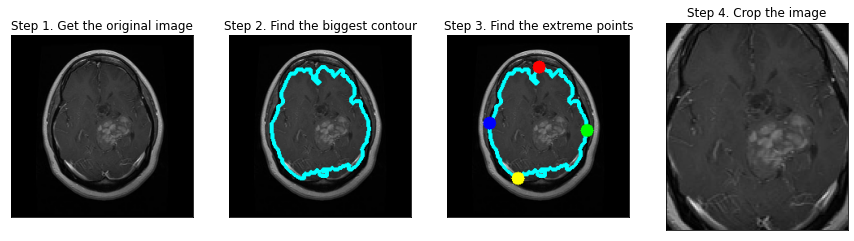

In [22]:
plt.figure(figsize=(15,6))

plt.subplot(1, 4, 1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')

plt.subplot(1, 4, 2)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')

plt.subplot(1, 4, 3)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')

plt.subplot(1, 4, 4)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [23]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


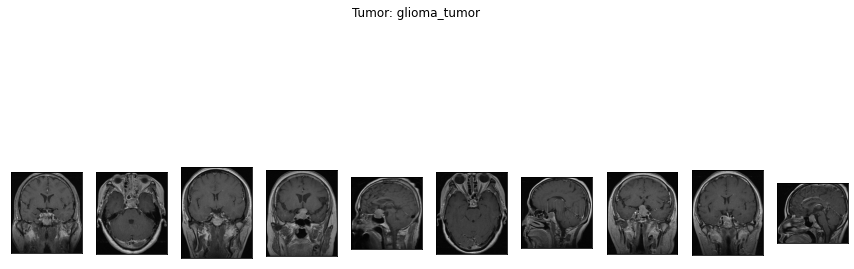

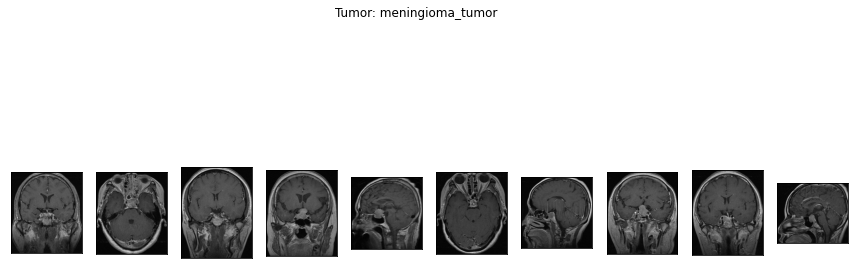

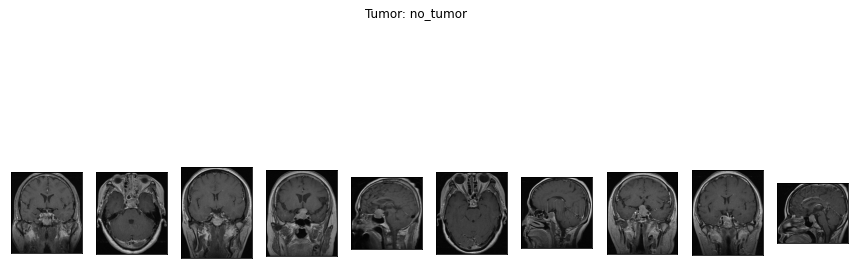

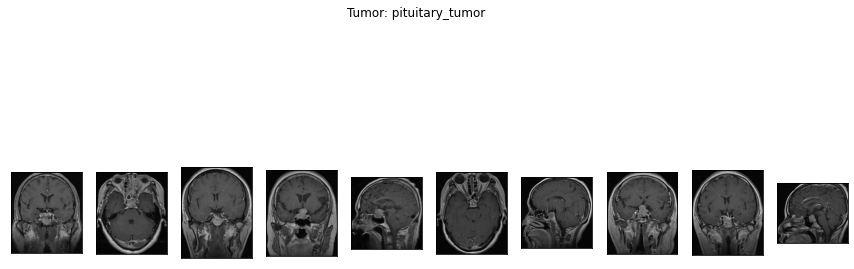

In [24]:
plot_samples(X_train_crop, y_train, labels, 10)

In [25]:
def save_new_images(x_set, y_set, directory_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(directory_name+'glioma_tumor/'+str(i)+'.jpg', img)
        elif imclass == 1:
            cv2.imwrite(directory_name+'meningioma_tumor/'+str(i)+'.jpg', img)
        elif imclass == 2:
            cv2.imwrite(directory_name+'no_tumor/'+str(i)+'.jpg', img)
        elif imclass == 3:
            cv2.imwrite(directory_name+'pituitary_tumor/'+str(i)+'.jpg', img)
        i += 4

In [26]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/glioma_tumor TRAIN_CROP/meningioma_tumor TRAIN_CROP/no_tumor TRAIN_CROP/pituitary_tumor TEST_CROP/glioma_tumor TEST_CROP/meningioma_tumor TEST_CROP/no_tumor TEST_CROP/pituitary_tumor VAL_CROP/glioma_tumor VAL_CROP/meningioma_tumor VAL_CROP/no_tumor VAL_CROP/pituitary_tumor

save_new_images(X_train_crop, y_train, directory_name = 'TRAIN_CROP/')
save_new_images(X_val_crop, y_val, directory_name = 'VAL_CROP/')
save_new_images(X_test_crop, y_test, directory_name = 'TEST_CROP/')

In [27]:
#The next step would be resizing images to (224,224) and applying preprocessing needed for ResNet50, VGG-16, Inception_v3 model input.

In [28]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply ResNet50, VGG-16, Inception_v3 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [29]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

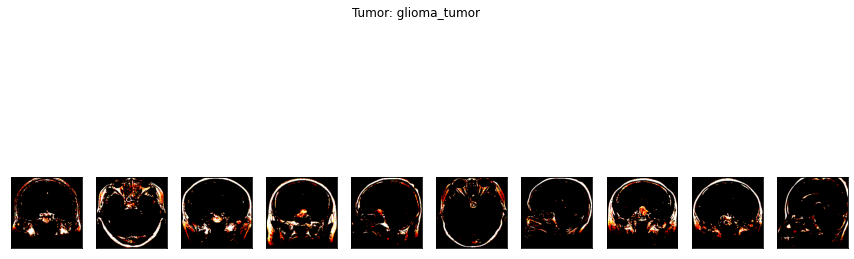

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

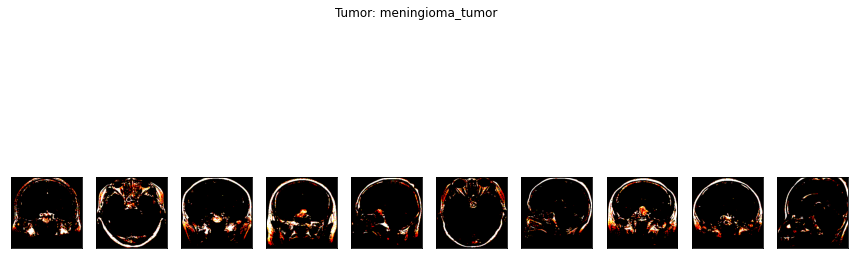

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

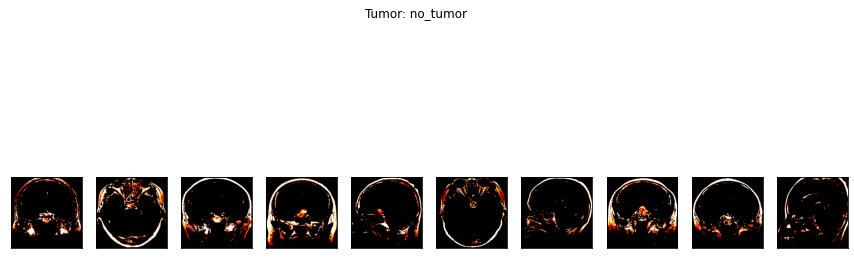

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

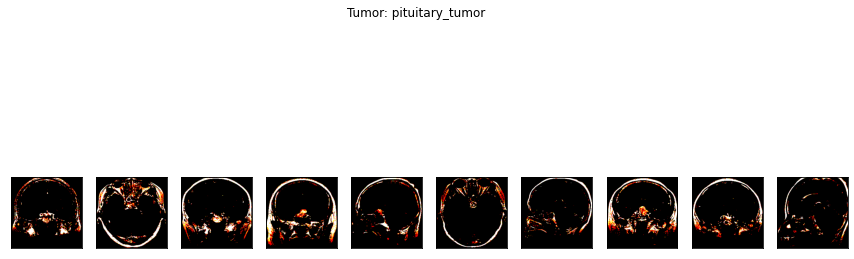

In [30]:
plot_samples(X_train_prep, y_train, labels, 10)

# Data Augmentation

In [31]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [32]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

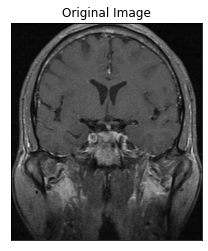

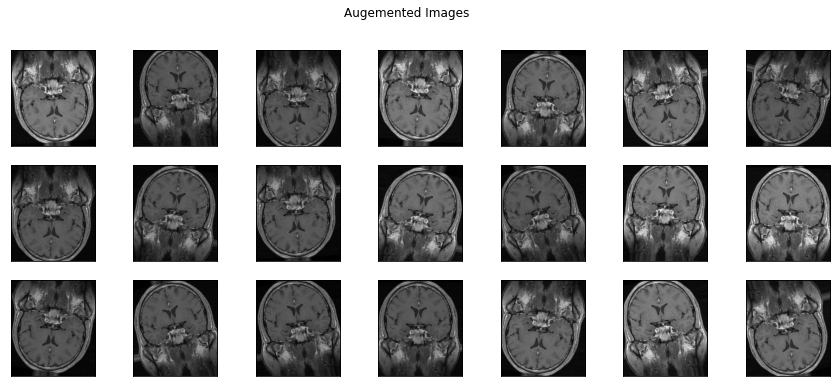

In [33]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [34]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

In [35]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [36]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=123
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=123)

Found 2644 images belonging to 4 classes.
Found 332 images belonging to 4 classes.


# Transfer Learning

# ResNet50

In [37]:
resnet50 = ResNet50(input_shape = IMG_SIZE + (3,), weights = "imagenet", include_top = False)

94781440/94765736 [==============================] - 1s 0us/step


In [38]:
for layer in resnet50.layers:
  layer.trainable = False

In [39]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [40]:
x1 = resnet50.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(128,activation='relu')(x1)
x1 = Dropout(0.15)(x1)
output1 = Dense(4,activation='softmax')(x1)

In [41]:
model1=Model(inputs=resnet50.input,outputs = output1)

In [42]:
model1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [44]:
len(model1.trainable_variables)

4

In [45]:
loss1, accuracy1 = model1.evaluate(validation_generator)

21/21 [==============================] - 50s 2s/step - loss: 2.0988 - accuracy: 0.2500


In [46]:
print("initial loss: {:.2f}".format(loss1))
print("initial accuracy: {:.2f}".format(accuracy1))

initial loss: 2.10
initial accuracy: 0.25


In [52]:
initial_epochs1 = 10
history1 = model1.fit_generator(train_generator, validation_data = validation_generator, epochs = initial_epochs1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
83/83 [==============================] - 438s 5s/step - loss: 1.3917 - accuracy: 0.2447 - val_loss: 1.3893 - val_accuracy: 0.2500
Epoch 2/10
83/83 [==============================] - 438s 5s/step - loss: 1.3909 - accuracy: 0.2383 - val_loss: 1.3889 - val_accuracy: 0.2500
Epoch 3/10
83/83 [==============================] - 439s 5s/step - loss: 1.3893 - accuracy: 0.2485 - val_loss: 1.3886 - val_accuracy: 0.2500
Epoch 4/10
83/83 [==============================] - 435s 5s/step - loss: 1.3900 - accuracy: 0.2470 - val_loss: 1.3883 - val_accuracy: 0.2500
Epoch 5/10
83/83 [==============================] - 435s 5s/step - loss: 1.3903 - accuracy: 0.2447 - val_loss: 1.3886 - val_accuracy: 0.2500
Epoch 6/10
83/83 [==============================] - 436s 5s/step - loss: 1.3909 - accuracy: 0.2322 - val_loss: 1.3887 - val_accuracy: 0.2500
Epoch 7/10
83/83 [==============================] - 437s 5s/step - loss: 1.3885 - accuracy: 0.2534 - val_loss: 1.3894 - val_accuracy: 0.2500
Epoch 8/10
83

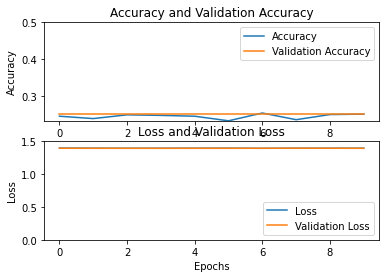

In [102]:
acc1 = history1.history["accuracy"]
val_acc1 =  history1.history["val_accuracy"]

loss1 = history1.history["loss"]
val_loss1 = history1.history["val_loss"]

plt.subplot(2, 1, 1)
plt.plot(acc1, label = "Accuracy")
plt.plot(val_acc1, label = "Validation Accuracy")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()),0.5])
plt.legend(loc='upper right')
plt.title("Accuracy and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss1, label = "Loss")
plt.plot(val_loss1, label = "Validation Loss")
plt.ylabel("Loss")
plt.ylim([0,1.5])
plt.legend(loc='lower right')
plt.title("Loss and Validation Loss")

plt.xlabel("Epochs")
plt.show()

# MobileNetV2

In [54]:
mobilenetv2 = MobileNetV2(input_shape = IMG_SIZE + (3,), weights = "imagenet", include_top = False)

9420800/9406464 [==============================] - 0s 0us/step


In [55]:
for layer in mobilenetv2.layers:
  layer.trainable = False

In [56]:
mobilenetv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [57]:
x2 = mobilenetv2.output
x2 = GlobalAveragePooling2D()(x2)
x2 = Dense(128,activation='relu')(x2)
x2 = Dropout(0.15)(x2)
output2 = Dense(4,activation='softmax')(x2)

In [58]:
model2 = Model(inputs = mobilenetv2.input,outputs = output2)

In [59]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [60]:
model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
len(model2.trainable_variables)

4

In [62]:
loss2, accuracy2 = model2.evaluate(validation_generator)

21/21 [==============================] - 11s 457ms/step - loss: 1.6862 - accuracy: 0.2500


In [63]:
print("initial loss: {:.2f}".format(loss2))
print("initial accuracy: {:.2f}".format(accuracy2))

initial loss: 1.69
initial accuracy: 0.25


In [68]:
initial_epochs2 = 10
history2 = model2.fit_generator(train_generator, validation_data = validation_generator, epochs = initial_epochs2)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
83/83 [==============================] - 112s 1s/step - loss: 1.4174 - accuracy: 0.2360 - val_loss: 1.3998 - val_accuracy: 0.2500
Epoch 2/10
83/83 [==============================] - 113s 1s/step - loss: 1.4080 - accuracy: 0.2439 - val_loss: 1.3952 - val_accuracy: 0.2500
Epoch 3/10
83/83 [==============================] - 112s 1s/step - loss: 1.4015 - accuracy: 0.2424 - val_loss: 1.3959 - val_accuracy: 0.2500
Epoch 4/10
83/83 [==============================] - 113s 1s/step - loss: 1.4006 - accuracy: 0.2583 - val_loss: 1.3930 - val_accuracy: 0.2500
Epoch 5/10
83/83 [==============================] - 111s 1s/step - loss: 1.3986 - accuracy: 0.2598 - val_loss: 1.3923 - val_accuracy: 0.2500
Epoch 6/10
83/83 [==============================] - 112s 1s/step - loss: 1.3965 - accuracy: 0.2523 - val_loss: 1.3900 - val_accuracy: 0.2500
Epoch 7/10
83/83 [==============================] - 112s 1s/step - loss: 1.3937 - accuracy: 0.2451 - val_loss: 1.3905 - val_accuracy: 0.2500
Epoch 8/10
83

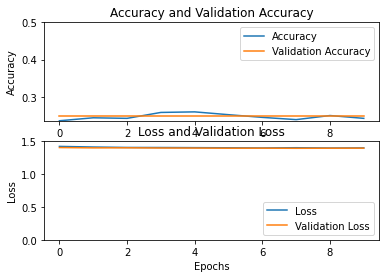

In [101]:
acc2 = history2.history["accuracy"]
val_acc2 =  history2.history["val_accuracy"]

loss2 = history2.history["loss"]
val_loss2 = history2.history["val_loss"]

plt.subplot(2, 1, 1)
plt.plot(acc2, label = "Accuracy")
plt.plot(val_acc2, label = "Validation Accuracy")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()),0.5])
plt.legend(loc='upper right')
plt.title("Accuracy and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss2, label = "Loss")
plt.plot(val_loss2, label = "Validation Loss")
plt.ylabel("Loss")
plt.ylim([0,1.5])
plt.legend(loc='lower right')
plt.title("Loss and Validation Loss")

plt.xlabel("Epochs")
plt.show()

# InceptionV3

In [86]:
inceptionv3 = InceptionV3(input_shape = IMG_SIZE + (3,), weights = "imagenet", include_top = False)

87924736/87910968 [==============================] - 1s 0us/step


In [87]:
for layer in inceptionv3.layers:
  layer.trainable = False

In [88]:
inceptionv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [89]:
x3 = inceptionv3.output
x3 = GlobalAveragePooling2D()(x3)
x3 = Dense(128,activation='relu')(x3)
x3 = Dropout(0.15)(x3)
output3 = Dense(4,activation='softmax')(x3)

In [91]:
model3 = Model(inputs = inceptionv3.input,outputs = output3)

In [92]:
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [93]:
model3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [94]:
len(model3.trainable_variables)

4

In [95]:
loss3, accuracy3 = model3.evaluate(validation_generator)

21/21 [==============================] - 34s 2s/step - loss: 16.4610 - accuracy: 0.2500


In [97]:
print("initial loss: {:.2f}".format(loss3))
print("initial accuracy: {:.2f}".format(accuracy3))

initial loss: 16.46
initial accuracy: 0.25


In [98]:
initial_epochs3 = 10
history3 = model3.fit_generator(train_generator, validation_data = validation_generator, epochs = initial_epochs3)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
83/83 [==============================] - 327s 4s/step - loss: 8.2992 - accuracy: 0.2655 - val_loss: 3.4791 - val_accuracy: 0.2500
Epoch 2/10
Epoch 2/10
83/83 [==============================] - 315s 4s/step - loss: 3.7848 - accuracy: 0.2583 - val_loss: 1.9666 - val_accuracy: 0.2500
Epoch 3/10
Epoch 3/10
83/83 [==============================] - 324s 4s/step - loss: 2.0653 - accuracy: 0.2375 - val_loss: 1.4393 - val_accuracy: 0.2500
Epoch 4/10
Epoch 4/10
83/83 [==============================] - 314s 4s/step - loss: 1.4984 - accuracy: 0.2345 - val_loss: 1.4151 - val_accuracy: 0.2500
Epoch 5/10
Epoch 5/10
83/83 [==============================] - 319s 4s/step - loss: 1.4143 - accuracy: 0.2606 - val_loss: 1.3965 - val_accuracy: 0.2500
Epoch 6/10
Epoch 6/10
83/83 [==============================] - 317s 4s/step - loss: 1.3991 - accuracy: 0.2508 - val_loss: 1.3886 - val_accuracy: 0.2500
Epoch 7/10
Epoch 7/10
83/83 [==============================] - 313s 4s/step - loss: 1.3964 - accura

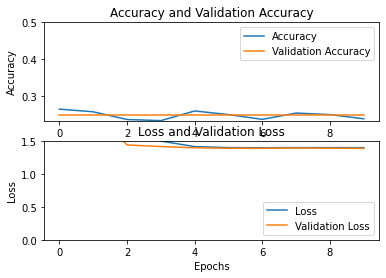

In [100]:
acc3 = history3.history["accuracy"]
val_acc3 =  history3.history["val_accuracy"]

loss3 = history3.history["loss"]
val_loss3 = history3.history["val_loss"]

plt.subplot(2, 1, 1)
plt.plot(acc3, label = "Accuracy")
plt.plot(val_acc3, label = "Validation Accuracy")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()),0.5])
plt.legend(loc='upper right')
plt.title("Accuracy and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss3, label = "Loss")
plt.plot(val_loss3, label = "Validation Loss")
plt.ylabel("Loss")
plt.ylim([0,1.5])
plt.legend(loc='lower right')
plt.title("Loss and Validation Loss")

plt.xlabel("Epochs")
plt.show()

# Prediction

In [75]:
# Retrieve a batch of images from the test set
image_batch, label_batch = validation_generator.next()
predictions = model1.predict_on_batch(image_batch).flatten()

In [76]:
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

In [ ]:
accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % accuracy)

In [77]:
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [3. 3. 2. 1. 0. 1. 0. 2. 3. 0. 1. 0. 0. 0. 3. 3.]


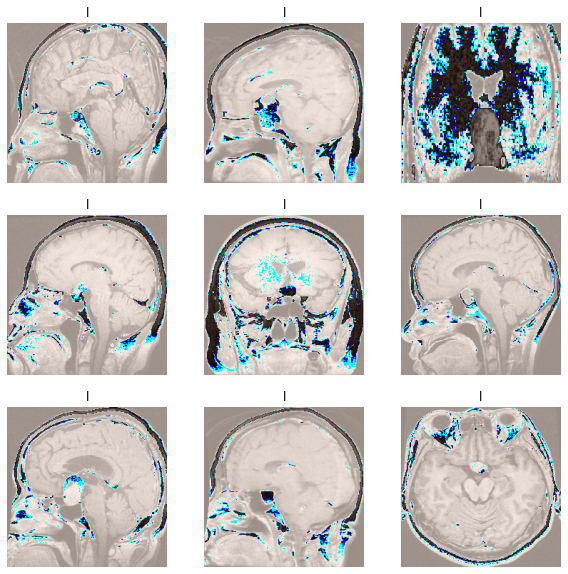

In [79]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(category[predictions[i]])
  plt.axis("off")